In [1]:
from PIL import Image,ImageDraw
import os.path as osp
import math
import json
import os
import torch
import numpy as np
import cv2
import albumentations as A
from torch.utils.data import Dataset
from shapely.geometry import Polygon
from functools import partial
from augmentation import generate_roi_mask
from matplotlib import pyplot as plt
from augmentation import *

In [6]:
def filter_vertices(vertices, labels, ignore_under=0, drop_under=0):
    if drop_under == 0 and ignore_under == 0:
        return vertices, labels

    new_vertices, new_labels = vertices.copy(), labels.copy()

    areas = np.array([Polygon(v.reshape((4, 2))).convex_hull.area for v in vertices])
    labels[areas < ignore_under] = 0

    if drop_under > 0:
        passed = areas >= drop_under
        new_vertices, new_labels = new_vertices[passed], new_labels[passed]

    return new_vertices, new_labels

class SceneTextDataset(Dataset):
    def __init__(self, root_dir,
                 split='train',
                 image_size=2048,
                 crop_size=1024,
                 ignore_tags=[],
                 ignore_under_threshold=10,
                 drop_under_threshold=1,
                 color_jitter=True,
                 normalize=True,
                 aug_list=[]):
        with open(osp.join(root_dir, 'ufo/{}.json'.format(split)), 'r') as f:
            anno = json.load(f)

        self.anno = anno
        self.image_fnames = sorted(anno['images'].keys())
        self.image_dir = osp.join(root_dir, 'img', split)

        self.image_size, self.crop_size = image_size, crop_size
        self.color_jitter, self.normalize = color_jitter, normalize

        self.ignore_tags = ignore_tags

        self.drop_under_threshold = drop_under_threshold
        self.ignore_under_threshold = ignore_under_threshold

        self.aug_list = aug_list
    def __len__(self):
        return len(self.image_fnames)

    def __getitem__(self, idx):
        image_fname = self.image_fnames[idx]
        image_fpath = osp.join(self.image_dir, image_fname)

        vertices, labels = [], []
        masking_vertices = []
        for word_info in self.anno['images'][image_fname]['words'].values():
            word_tags = word_info['tags']

            ignore_sample = any(elem for elem in word_tags if elem in self.ignore_tags)
            num_pts = np.array(word_info['points']).shape[0]

            # skip samples with ignore tag and
            # samples with number of points greater than 4
            if ignore_sample :
                continue
            if num_pts > 4:
                print(list(map(tuple,word_info['points'])))
                masking_vertices.append(list(map(tuple,word_info['points'])))
                continue
            vertices.append(np.array(word_info['points']).flatten())
            labels.append(int(not word_info['illegibility']))
        vertices, labels = np.array(vertices, dtype=np.float32), np.array(labels, dtype=np.int64)

        vertices, labels = filter_vertices(
            vertices,
            labels,
            ignore_under=self.ignore_under_threshold,
            drop_under=self.drop_under_threshold
        )

        image = Image.open(image_fpath)
        if masking_vertices:
            AnotationMasking(image,masking_vertices)
        if self.aug_list:
            image,vertices,labels=process_augmentation(image,vertices,labels,self.aug_list)
        else:
            if image.mode != 'RGB':
                image = image.convert('RGB')
            image = np.array(image)
    
        word_bboxes = np.reshape(vertices, (-1, 4, 2))
        roi_mask = generate_roi_mask(image, vertices, labels)

        return image, word_bboxes, roi_mask
    

[(181.34292039831794, 175.01403416291527), (335.989249671577, 157.69842200490555), (510.3395514005022, 170.23731356760226), (510.93664147491637, 219.1986996695607), (341.36306034130416, 209.64525847893466), (181.34292039831794, 226.36378056253022)]
[(207.19026387472317, 428.2721308627331), (363.0307732968105, 410.3594286303093), (478.2691576587371, 419.31577974652123), (480.0604278819795, 476.63642689027745), (367.21040381770933, 464.6946254019949), (207.19026387472317, 482.60732763441877)]
[(181.34292039831794, 175.01403416291527), (335.989249671577, 157.69842200490555), (510.3395514005022, 170.23731356760226), (510.93664147491637, 219.1986996695607), (341.36306034130416, 209.64525847893466), (181.34292039831794, 226.36378056253022)]
[(207.19026387472317, 428.2721308627331), (363.0307732968105, 410.3594286303093), (478.2691576587371, 419.31577974652123), (480.0604278819795, 476.63642689027745), (367.21040381770933, 464.6946254019949), (207.19026387472317, 482.60732763441877)]
[(181.34

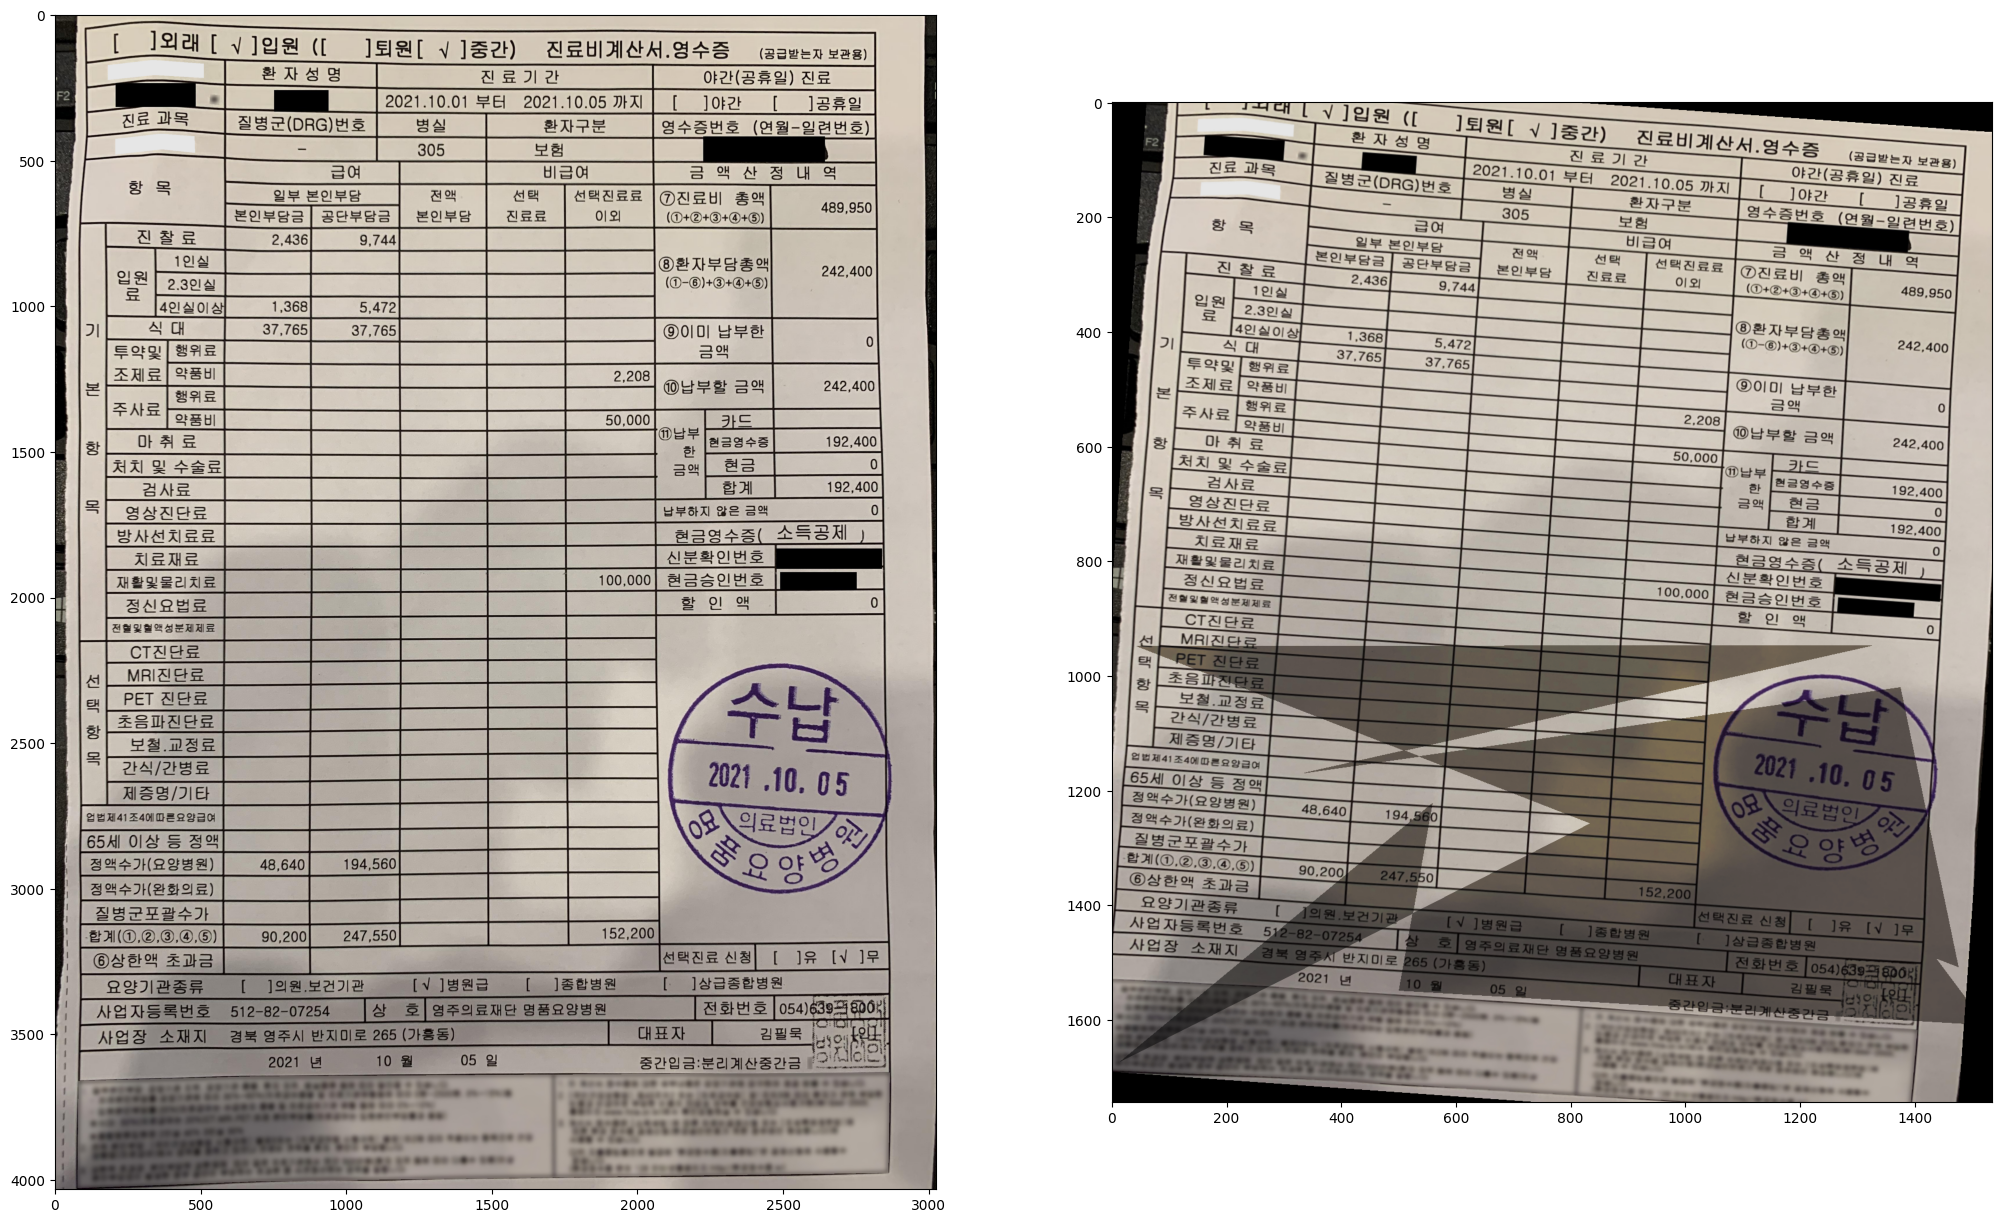

In [7]:
data_dir = os.environ.get('SM_CHANNEL_TRAIN', '../../data/medical')
image_size = 2048
input_size = 1024
ignore_tags = ['masked', 'excluded-region', 'maintable', 'stamp']

test_aug = []
# test_aug = ['Resize','Rotate','ToNumpy','ColorJitter']

dataset = SceneTextDataset(
data_dir,
split='train',
image_size=image_size,
crop_size=input_size,
ignore_tags=ignore_tags,
aug_list=test_aug
)

idx=93
img=dataset[idx]

plt.figure(figsize=(25,40))
plt.subplot(1,2,1)
plt.imshow(img[0])


plt.subplot(1,2,2)
dataset.aug_list=['Resize','AdjustHeight','Rotate','ToNumpy','RandomShadow']
img=dataset[idx]
print(img[0].max(),img[0].min())
plt.imshow(img[0])

